# Survival Analysis in Python

Fertility data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empyrical_dist import Pmf, Cdf, Surv, Hazard

Read the tables from [National Survey of Family Growth](https://www.cdc.gov/nchs/nsfg/index.htm), specifically [2015-2017 NSFG: Public-Use Data Files](https://www.cdc.gov/nchs/nsfg/nsfg_2015_2017_puf.htm)

[Here is the codebook](https://www.icpsr.umich.edu/icpsradmin/nsfg/index?studyNumber=10001)

And here are the data files we need.

[2015_2017_FemRespData.dat](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat)

[2015_2017_FemRespSetup.dct](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct)


Data User's Agreement

Federal law (The Public Health Service Act (Section 308 (d))) provides that these data may be used only for the purpose of health statistical reporting and analysis. Any effort to determine the identity of any person or establishment is prohibited by this law.

NCHS does all it can to assure that the identity of data subjects cannot be disclosed. All direct identifiers, as well as any characteristics that might lead to identification, are omitted from the data files. In addition, some records have had one or more responses slightly modified through statistical perturbation. These modifications are intended to prevent definitive identification of individual respondents. They do not affect univariate point estimates and have a minimal effect on estimates of variance and tests of statistical significance.

By downloading National Survey of Family Growth data, you signify your agreement to comply with the following legal requirements:

1. To use these data for statistical reporting and analysis only;
2. To make no use of the identity of any person or establishment discovered inadvertently and advise the Director, NCHS, of any such discovery (301-458-4500); and
3. To not link these data with individually identifiable data from any other data set.

In [2]:
### To download the data, uncomment the following lines and run this cell

# !cd data
# !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/2015_2017_FemRespData.dat
# !wget ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NSFG/stata/2015_2017_FemRespSetup.dct
# !cd ..

In [3]:
df = utils.read_stata('data/2015_2017_FemRespSetup.dct', 'data/2015_2017_FemRespData.dat')
df.head()

,CASEID,RSCRNINF,RSCRAGE,RSCRHISP,RSCRRACE,AGE_A,AGE_R,AGESCRN,HISP,HISPGRP,...,SEST,CMINTVW,CMLSTYR,CMJAN3YR,CMJAN4YR,CMJAN5YR,QUARTER,PHASE,INTVWYEAR,INTVLNGTH
0,70623,5,16,5.0,3.0,16,16,16,5,NaN,...,322,1390,1378,1345,1333,1321,17,1,2015,35.04
1,70624,1,40,5.0,1.0,40,40,40,5,NaN,...,331,1394,1382,1357,1345,1333,18,1,2016,61.01
2,70625,5,15,5.0,2.0,15,15,15,5,NaN,...,366,1402,1390,1357,1345,1333,21,1,2016,40.35
3,70627,1,35,5.0,3.0,35,35,35,5,NaN,...,322,1394,1382,1357,1345,1333,18,1,2016,64.79
4,70628,1,28,5.0,2.0,28,28,28,5,NaN,...,366,1409,1397,1369,1357,1345,23,1,2017,77.86


In [4]:
np.random.seed(17)
df = utils.resample_rows_weighted(df, 'WGT2015_2017')

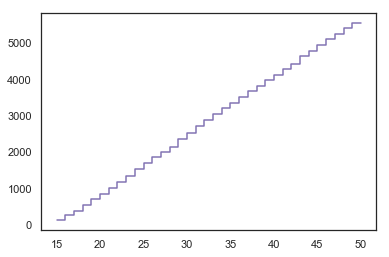

In [5]:
cdf_ager = Cdf.from_seq(df['AGER'], normalize=False)
cdf_ager.step()

In [6]:
cdf_ager.head()

15    118
16    267
17    384
18    546
19    705
Name: AGER, dtype: int64

In [7]:
cdf_ager.tail()

46    5117
47    5238
48    5396
49    5553
50    5554
Name: AGER, dtype: int64

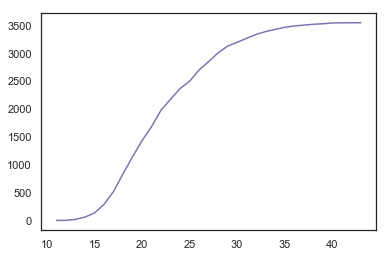

In [8]:
cdf_ageprg01 = Cdf.from_seq(df['AGEPRG01'], normalize=False)
cdf_ageprg01.plot()

In [9]:
for i in range(1, 20):
    var = 'AGEPRG%2.2d' % i
    print(df[var].isnull().sum())

2007
2850
3737
4638
5141
5401
5482
5523
5537
5541
5544
5545
5545
5546
5549
5549
5549
5549
5549


In [10]:
for i in range(1, 21):
    var = 'OUTCOM%2.2d' % i
    print(df[var].isnull().sum())

1956
2810
3705
4608
5134
5400
5482
5523
5537
5539
5544
5545
5545
5546
5549
5549
5549
5549
5549
5549


In [11]:
ages_prg = []
for i, row in df.iterrows():
    for prgnum in range(1, 21):
        outcom = 'OUTCOM%2.2d' % prgnum
        ageprg = 'AGEPRG%2.2d' % prgnum
        if row[outcom] == 1:
            ages_prg.append(row[ageprg])

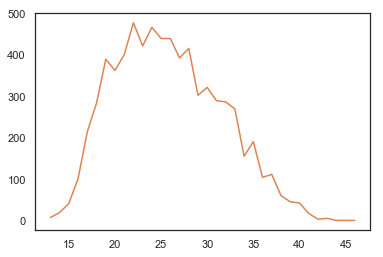

In [12]:
pmf_ageprg = Pmf.from_seq(ages_prg, normalize=False)
pmf_ageprg.plot()

15    118
16    149
17    117
18    162
19    159
Name: AGER, dtype: int64

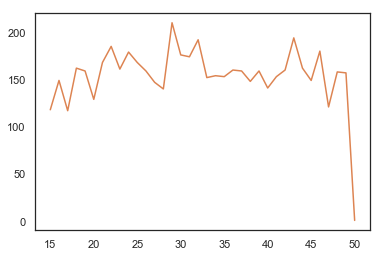

In [13]:
pmf_ager = Pmf.from_seq(df['AGER'], normalize=False)
pmf_ager.plot()
pmf_ager.head()

15    5436
16    5287
17    5170
18    5008
19    4849
Name: AGER, dtype: int64

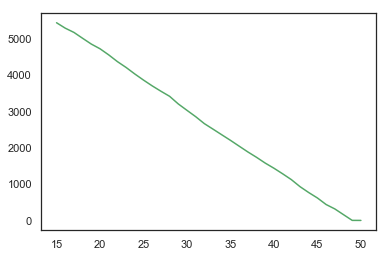

In [14]:
surv_ager = pmf_ager.make_surv(normalize=False)
surv_ager.plot()
surv_ager.head()

In [19]:
denom = surv_ager + pmf_ager
denom.head()

15    5554
16    5436
17    5287
18    5170
19    5008
Name: AGER, dtype: int64

In [20]:
np.sum(df['AGER'] >= 15)

5554

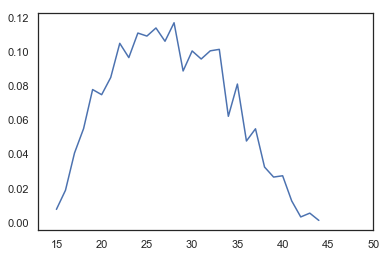

In [21]:
asfr = pd.Series.div(pmf_ageprg, denom)
asfr.plot()

In [22]:
asfr.sum()

1.9617634593652393